In [ ]:
import sys
if 'google.colab' in sys.modules:  # colab特有の処理_2回目以降
  # Google Driveのマウント
  from google.colab import drive
  drive.mount('/content/drive')

  # ライブラリのパス指定
  sys.path.append('/content/drive/MyDrive/Colab_Files/kaggle/commonlit/XX_modules')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# データセットをDriveから取得
!mkdir -p 'input'
!mkdir -p 'clrp-pre-trained'

!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/00_input/commonlitreadabilityprize/' '/content/input'
!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/97_pre_trained/clrp_pretrained_manish_epoch5/pre-trained-roberta/clrp_roberta_large/' '/content/clrp-pre-trained'

In [ ]:
from pathlib import Path

# input
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = Path('../input/commonlitreadabilityprize/')

elif 'google.colab' in sys.modules: # Colab環境
    DATA_DIR = Path('/content/input/commonlitreadabilityprize')

else:
    DATA_DIR = Path('../00_input/commonlitreadabilityprize/')

In [ ]:
from pathlib import Path

# tokenizer
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    TOKENIZER_DIR = '../input/roberta-transformers-pytorch/roberta-large'
elif 'google.colab' in sys.modules: # Colab環境
    TOKENIZER_DIR = '/content/clrp-pre-trained/clrp_roberta_large' # 仮で、毎回DLする想定のモデル名を指定。あとで変更予定。
else:
    TOKENIZER_DIR = 'roberta-large'

In [ ]:
from pathlib import Path

# pre-trained model
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    PRE_TRAINED_MODEL_DIR = '../input/roberta-transformers-pytorch/roberta-large'
elif 'google.colab' in sys.modules: # Colab環境
    PRE_TRAINED_MODEL_DIR = '/content/clrp-pre-trained/clrp_roberta_large' # 仮で、毎回DLする想定のモデル名を指定。あとで変更予定。
else:
    PRE_TRAINED_MODEL_DIR = 'roberta-large'

In [ ]:
UPLOAD_DIR = Path('/content/model')
EX_NO = '056-train-01'  # 実験番号などを入れる、folderのpathにする
USERID = 'calpis10000'

In [ ]:
import subprocess
import shlex

def gpuinfo():
    """
    Returns size of total GPU RAM and used GPU RAM.

    Parameters
    ----------
    None

    Returns
    -------
    info : dict
        Total GPU RAM in integer for key 'total_MiB'.
        Used GPU RAM in integer for key 'used_MiB'.
    """

    command = 'nvidia-smi -q -d MEMORY | sed -n "/FB Memory Usage/,/Free/p" | sed -e "1d" -e "4d" -e "s/ MiB//g" | cut -d ":" -f 2 | cut -c2-'
    commands = [shlex.split(part) for part in command.split(' | ')]
    for i, cmd in enumerate(commands):
        if i==0:
            res = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        else:
            res = subprocess.Popen(cmd, stdin=res.stdout, stdout=subprocess.PIPE)
    total, used = map(int, res.communicate()[0].decode('utf-8').strip().split('\n'))
    info = {'total_MiB':total, 'used_MiB':used}
    return info


# Overview
This nb is based on copy from https://www.kaggle.com/andretugan/lightweight-roberta-solution-in-pytorch .

Acknowledgments(from base nb): 
some ideas were taken from kernels by [Torch](https://www.kaggle.com/rhtsingh) and [Maunish](https://www.kaggle.com/maunish).

In [ ]:
import os
import math
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW # optimizer
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup # scheduler
from pytorch_memlab import profile
import pytorch_memlab
from pytorch_memlab import MemReporter

from sklearn.model_selection import KFold, StratifiedKFold

import gc
gc.enable()

In [ ]:
NUM_FOLDS = 5 # K Fold
NUM_EPOCHS = 5 # Epochs
BATCH_SIZE = 12 # Batch Size
MAX_LEN = 248 # ベクトル長
EVAL_SCHEDULE = [(0.55, 64), (-1., 32)] # schedulerの何らかの設定？
ROBERTA_PATH = PRE_TRAINED_MODEL_DIR # roberta pre-trainedモデル(モデルとして指定)
TOKENIZER_PATH = TOKENIZER_DIR # roberta pre-trainedモデル(Tokenizerとして指定)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # cudaがなければcpuを使えばいいじゃない

In [ ]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True# cudnnによる最適化で結果が変わらないためのおまじない 

In [ ]:
# read train_df(kfold)
train_kf_df = pd.read_csv(DATA_DIR/"train_kfold.csv")

In [ ]:
# tokenizerを指定
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

# Dataset

In [ ]:
# 前処理用
import string
import re
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text

def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# センテンス特徴付きのデータセット
class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only # Testデータ用フラグ
        self.text = df.excerpt.tolist() # 分析対象カラムをlistにする。(分かち書きではなく、Seriesをlistへ変換するような処理)
        #self.text = [text.replace("\n", " ") for text in self.text] # 単語単位で分かち書きする場合
        self.text_len = text_normalization(df.excerpt).map(lambda x: [0 if i >= len(x.split(' ')) else len(x.split(' ')[i]) for i in range(132)])
        self.sentences = df['excerpt'].map(lambda x: x.split('.')).map(lambda x: [0 if i >= len(x) else len(x[i]) for i in range(36)])

        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32) # trainのみ、targetをtensorに変換
            self.standard_error = torch.tensor(df.standard_error.values, dtype=torch.float32) 

        self.encoded = tokenizer.batch_encode_plus( # textをtokenize
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True, # 最大長を超える文字は切り捨て
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index): # 変換結果を返す
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        input_len = torch.tensor(self.text_len.iloc[index], dtype=torch.float32)
        input_sentence = torch.tensor(self.sentences.iloc[index], dtype=torch.float32)

        if self.inference_only:
            return (input_ids, attention_mask, input_len, input_sentence)            
        else:
            target = self.target[index]
            standard_error = self.standard_error[index]
            return (input_ids, attention_mask, input_len, input_sentence, target, standard_error)

# Model
The model is inspired by the one from [Maunish](https://www.kaggle.com/maunish/clrp-roberta-svm).

In [ ]:
class LitModel(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH) # pretrainedからconfigを読み込み
        config.update({"output_hidden_states":True, # config更新: embedding層を抽出
                       "hidden_dropout_prob": 0.0, # config更新: dropoutしない
                       "layer_norm_eps": 1e-7}) # config更新: layer normalizationのepsilon                      
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config) # cpuで処理する
            
        self.attention = nn.Sequential(# attentionレイヤー            
            nn.Linear(config.hidden_size, 512),      
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )

        self.mlm_layers = nn.Sequential(
            nn.Linear(132, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )

        self.mlm_sentence = nn.Sequential(
            nn.Linear(36, 18),
            nn.BatchNorm1d(18),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(18, 18),
        )


        self.regressor = nn.Sequential( # 出力レイヤー                    
            nn.Linear(config.hidden_size + 64 + 18, 2)                        
        )

    def forward(self, input_ids, attention_mask, input_len, input_sentence):
        roberta_output = self.roberta(input_ids=input_ids, # robertaに入力データを流し、出力としてrobertaモデル(layerの複合体)を得る
                                      attention_mask=attention_mask)     
        # attention_pooling
        last_hidden_state = roberta_output.hidden_states[-1] # robertaモデルの最後のlayerを得る
        weights = self.attention(last_hidden_state) # robertaの最後のlayerをattentionへ入力し、出力として重みを得る                
        context_vector = torch.sum(weights * last_hidden_state, dim=1) # 重み×最後の層を足し合わせて文書ベクトルとする。

        # word_length_conv1d
        #input_chnl = input_len.unsqueeze(1)
        #conv1_layers = self.conv1_layers(input_chnl)
        #conv1_layers_v = conv1_layers.view(conv1_layers.size(0),-1)

        # word_length_mlm
        mlm_layers = self.mlm_layers(input_len)
        mlm_sentence = self.mlm_sentence(input_sentence)


        # https://www.kaggle.com/rhtsingh/utilizing-transformer-representations-efficiently
        # last_hidden_state = roberta_output[0]
        # input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        # sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        # sum_mask = input_mask_expanded.sum(1)
        # sum_mask = torch.clamp(sum_mask, min=1e-9)
        # mean_embeddings = sum_embeddings / sum_mask

        # concat_embeddings
        cat_embeddings = torch.cat([context_vector, mlm_layers, mlm_sentence], dim=1)        
        return self.regressor(cat_embeddings) # 文書ベクトルを線形層に入力し、targetを出力する
        
        # Now we reduce the context vector to the prediction score.
        #return self.regressor(mean_embeddings) # 文書ベクトルを線形層に入力し、targetを出力する

In [ ]:
def eval_mse(model, data_loader):
    """Evaluates the mean squared error of the |model| on |data_loader|"""
    model.eval() # evalモードを選択。Batch Normとかdropoutをしなくなる           
    mse_mean_sum = 0
    mse_std_sum = 0

    with torch.no_grad(): # 勾配の計算をしないBlock
        for batch_num, (input_ids, attention_mask, input_len, input_sentence, target, standard_error) in enumerate(data_loader): # data_loaderからinput, attentin_mask, targetをbatchごとに取り出す
            input_ids = input_ids.to(DEVICE)   
            attention_mask = attention_mask.to(DEVICE)  
            input_len = input_len.to(DEVICE) 
            input_sentence = input_sentence.to(DEVICE)
            target = target.to(DEVICE)      
            standard_error = standard_error.to(DEVICE) 
            
            output = model(input_ids, attention_mask, input_len, input_sentence) # 取得した値をモデルへ入力し、出力として予測値を得る。

            mse_mean_sum += nn.MSELoss(reduction="sum")(output[:,0].flatten(), target).item() # 誤差の合計を得る(Batchごとに計算した誤差を足し上げる)
            mse_std_sum += nn.MSELoss(reduction="sum")(output[:,1].flatten(), target).item() # 誤差の合計を得る(Batchごとに計算した誤差を足し上げる)

    del input_ids
    del attention_mask
    del target

    mse_mean_result = mse_mean_sum / len(data_loader.dataset)
    mse_std_result = mse_std_sum / len(data_loader.dataset)
  
    return mse_mean_result, mse_std_result # 誤差の合計をdataset長で除し、mseを取得＆返す

In [ ]:
# 推論結果を返す
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval() # evalモード(dropout, batch_normしない)

    result = np.zeros(len(data_loader.dataset)) # 結果をdataset長のzero配列として用意
    index = 0
    
    with torch.no_grad(): # 勾配の計算をしないblock(inputすると、現状の重みによる推論結果を返す)
        for batch_num, (input_ids, attention_mask, input_len, input_sentence) in enumerate(data_loader): # data_loaderからbatchごとにinputを得る
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            input_len = input_len.to(DEVICE)
            input_sentence = input_sentence.to(DEVICE)
                        
            output = model(input_ids, attention_mask, input_len, input_sentence) # modelにinputを入力し、予測結果を得る。

            result[index : index + output[:,0].shape[0]] = output[:,0].flatten().to("cpu") # result[index ~ predの長さ]へ、予測結果を格納
            index += output.shape[0] # indexを更新

    return result # 全batchで推論が終わったら、結果を返す

In [ ]:
# 学習
def train(model, # モデル
          model_path, # モデルのアウトプット先
          train_loader, # train-setのdata_loader
          val_loader, # valid-setのdata_loader
          optimizer, # optimizer
          scheduler=None, # scheduler, デフォルトはNone
          num_epochs=NUM_EPOCHS # epoch数、notebook冒頭で指定した値
         ):    
    
    best_val_rmse = None
    best_epoch = 0
    step = 0
    last_eval_step = 0
    eval_period = EVAL_SCHEDULE[0][1] # eval期間(って何？) 冒頭で決めたEVAL_SCHEDULEの最初のtupleの[1]を取得

    start = time.time() # 時間計測用

    for epoch in range(num_epochs): # 指定したEpoch数だけ繰り返し
        val_rmse = None         

        for batch_num, (input_ids, attention_mask, input_len, input_sentence, target, standard_error) in enumerate(train_loader): # train_loaderからinput, targetを取得
            input_ids = input_ids.to(DEVICE) # inputをDEVICEへ突っ込む
            attention_mask = attention_mask.to(DEVICE)   
            input_len = input_len.to(DEVICE)
            input_sentence = input_sentence.to(DEVICE)
            target = target.to(DEVICE)
            standard_error = standard_error.to(DEVICE)  

            optimizer.zero_grad() # 勾配を初期化            
            model.train() # 学習モード開始

            # https://www.kaggle.com/c/commonlitreadabilityprize/discussion/239421
            output = model(input_ids, attention_mask, input_len, input_sentence) # input,attention_maskを入力し、予測結果を得る
            p = torch.distributions.Normal(output[:,0], torch.sqrt(output[:,1]**2))
            q = torch.distributions.Normal(target, standard_error)
            kl_vector = torch.distributions.kl_divergence(p, q)
            loss = kl_vector.mean()

            loss.backward() # 誤差逆伝播法により勾配を得る
            optimizer.step() # 重みを更新する

            if scheduler:
                scheduler.step() # schedulerが与えられた場合は、schedulerの学習率更新
            
            if step >= last_eval_step + eval_period: # batchを回すごとにstepを増やしていって、「前回evalしたstep + eval_period(16)」を超えたら実行。
                # Evaluate the model on val_loader.
                elapsed_seconds = time.time() - start # 経過時間
                num_steps = step - last_eval_step # 経過ステップ数
                print(f"\n{num_steps} steps took {elapsed_seconds:0.3} seconds")
                last_eval_step = step # 前回stepの更新
                
                # valid-setによるrmse計算
                train_mean_mse = nn.MSELoss(reduction="mean")(output[:,0].flatten(), target) 
                train_std_mse = nn.MSELoss(reduction="mean")(torch.sqrt(output[:,1]**2).flatten(), standard_error) 

                train_mean_rmse = math.sqrt(train_mean_mse)
                train_std_rmse = math.sqrt(train_std_mse)

                val_mean_mse, val_std_mse = eval_mse(model, val_loader)
                val_mean_rmse = math.sqrt(val_mean_mse)                            
                val_std_rmse = math.sqrt(val_std_mse)                            

                print(f"Epoch: {epoch} batch_num: {batch_num}")
                print(f"train_rmse_target: {train_mean_rmse:0.4}",
                      f"train_rmse_stderror: {train_std_rmse:0.4}",
                      f"train_kl_div: {loss:0.4}",
                      )
                print(f"val_rmse_target: {val_mean_rmse:0.4}",
                      f"val_rmse_stderror: {val_std_rmse:0.4}"
                      )

                for rmse, period in EVAL_SCHEDULE: # eval_periodをvalid-rmseで切り替える処理
                    if val_mean_rmse >= rmse: # valid rmseをEVAL_SCHEDULEと比較し、0項 > valid rmseとなるまで回す : EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
                        eval_period = period # eval_periodを更新
                        break                               

                if not best_val_rmse or val_mean_rmse < best_val_rmse: # 初回(best_val_rmse==None), またはbest_val_rmseを更新したらモデルを保存する
                    best_val_rmse = val_mean_rmse
                    best_epoch = epoch
                    torch.save(model.state_dict(), model_path) # 最高の自分を保存
                    print(f"New best_val_rmse: {best_val_rmse:0.4}")
                else:       
                    print(f"Still best_val_rmse: {best_val_rmse:0.4}", # 更新されない場合は、元のスコアを表示
                          f"(from epoch {best_epoch})")      
                                                  
                start = time.time()
            
            # batchごとにメモリ解放
            del input_ids
            del attention_mask
            del target
            torch.cuda.empty_cache()                                            
            step += 1
    
    return best_val_rmse

In [ ]:
# optimizerの作成
def create_optimizer(model):
    parameters = []

    named_parameters = list(model.named_parameters()) # モデルパラメータの取得
    roberta_parameters = list(model.roberta.named_parameters())[:-2] # パラメータをroberta用、attention用、regressor用に格納。(直接引っ張ってくる形式に変更)

    attention_parameters = list(model.attention.named_parameters())
    attention_group = [{'params': params, 'lr': 2e-5} for (name, params) in attention_parameters] # attention用パラメータをリストとして取得
    parameters += attention_group

    #norm_parameters = list(model.layer_norm.named_parameters())
    #norm_group = [{'params': params, 'lr': 2e-5} for (name, params) in norm_parameters]
    #parameters += norm_group

    mlm_parameters = list(model.mlm_layers.named_parameters())
    mlm_group = [{'params': params, 'lr': 2e-5} for (name, params) in mlm_parameters] # reg用パラメータをリストとして取得
    parameters += mlm_group

    mlm_sent_parameters = list(model.mlm_sentence.named_parameters())
    mlm_sent_group = [{'params': params, 'lr': 2e-6, 'weight_decay': 0.0 if "bias" in name else 0.01} for (name, params) in mlm_sent_parameters] # reg用パラメータをリストとして取得
    parameters += mlm_sent_group

    regressor_parameters = list(model.regressor.named_parameters())
    regressor_group = [{'params': params, 'lr': 2e-5} for (name, params) in regressor_parameters] # reg用パラメータをリストとして取得
    parameters += regressor_group

    for layer_num, (name, params) in enumerate(roberta_parameters): # レイヤーごとにname, paramsを取得していろんな処理
        weight_decay = 0.0 if "bias" in name else 0.01

        lr = 8e-6

        if layer_num >= 69:        
            lr = 2e-5

        if layer_num >= 133:
            lr = 4e-5

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters) # 最終的に、AdamWにパラメータを入力する。


In [ ]:
def train_and_save_model(train_indices, val_indices, model_path):
    train_dataset = LitDataset(train_kf_df.loc[train_indices]) # train, validのDataset
    val_dataset = LitDataset(train_kf_df.loc[val_indices])
        
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              drop_last=True, shuffle=True, num_workers=2) # train, validのDataLoader
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            drop_last=False, shuffle=False, num_workers=2)    

    model = LitModel().to(DEVICE) # modelをDEVICEへぶち込む
    optimizer = create_optimizer(model) # optimizerをモデルから作成
    scheduler = get_cosine_schedule_with_warmup( # schedulerを作成
        optimizer,
        num_training_steps=NUM_EPOCHS * len(train_loader),
        num_warmup_steps=50)    
    rmse = train(model, model_path, train_loader, val_loader, optimizer, scheduler=scheduler)

    del train_dataset
    del val_dataset
    del train_loader
    del val_loader
    del model
    del optimizer
    del scheduler
    gc.collect() 
    torch.cuda.empty_cache()
    return rmse

In [ ]:
# 実行処理。 KFold & 学習
SEED = 1000
list_val_rmse = []

for fold in sorted(train_kf_df['kfold'].unique()):
    print(f"\nFold {fold + 1}/{NUM_FOLDS}")
    print(gpuinfo())
    model_path = f"model_{fold + 1}.pth" # model_fold数_.pth
    set_random_seed(SEED + fold) # SEEDはfold別に変わるようにする

    train_indices = (train_kf_df['kfold'] != fold)
    val_indices = (train_kf_df['kfold'] == fold)
    list_val_rmse.append(train_and_save_model(train_indices, val_indices, model_path))
    print("\nPerformance estimates:")
    print(list_val_rmse)
    print("Mean:", np.array(list_val_rmse).mean())
    print(gpuinfo())


Fold 1/5
{'total_MiB': 16160, 'used_MiB': 2}


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


64 steps took 49.4 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.8074 train_rmse_stderror: 0.119 train_kl_div: 1.228
val_rmse_target: 0.6574 val_rmse_stderror: 1.19
New best_val_rmse: 0.6574

64 steps took 48.9 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.5232 train_rmse_stderror: 0.1063 train_kl_div: 0.5665
val_rmse_target: 0.5584 val_rmse_stderror: 1.177
New best_val_rmse: 0.5584

64 steps took 49.2 seconds
Epoch: 1 batch_num: 4
train_rmse_target: 0.3609 train_rmse_stderror: 0.1205 train_kl_div: 0.3178
val_rmse_target: 0.5621 val_rmse_stderror: 1.126
Still best_val_rmse: 0.5584 (from epoch 0)

64 steps took 49.0 seconds
Epoch: 1 batch_num: 68
train_rmse_target: 0.7639 train_rmse_stderror: 0.06456 train_kl_div: 1.155
val_rmse_target: 0.5918 val_rmse_stderror: 1.15
Still best_val_rmse: 0.5584 (from epoch 0)

64 steps took 49.0 seconds
Epoch: 1 batch_num: 132
train_rmse_target: 0.5466 train_rmse_stderror: 0.09279 train_kl_div: 0.6734
val_rmse_target: 0.5267 val_rmse_stder

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


64 steps took 49.5 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.5625 train_rmse_stderror: 0.08782 train_kl_div: 0.6014
val_rmse_target: 0.5882 val_rmse_stderror: 1.128
New best_val_rmse: 0.5882

64 steps took 49.0 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.5019 train_rmse_stderror: 0.0372 train_kl_div: 0.4936
val_rmse_target: 0.5716 val_rmse_stderror: 1.124
New best_val_rmse: 0.5716

64 steps took 49.3 seconds
Epoch: 1 batch_num: 4
train_rmse_target: 0.4507 train_rmse_stderror: 0.07281 train_kl_div: 0.4024
val_rmse_target: 0.5255 val_rmse_stderror: 1.132
New best_val_rmse: 0.5255

32 steps took 24.5 seconds
Epoch: 1 batch_num: 36
train_rmse_target: 0.4636 train_rmse_stderror: 0.05795 train_kl_div: 0.4124
val_rmse_target: 0.5703 val_rmse_stderror: 1.13
Still best_val_rmse: 0.5255 (from epoch 1)

64 steps took 49.1 seconds
Epoch: 1 batch_num: 100
train_rmse_target: 0.4297 train_rmse_stderror: 0.0797 train_kl_div: 0.3945
val_rmse_target: 0.5094 val_rmse_stderror: 1.146
N

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


64 steps took 49.7 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.6728 train_rmse_stderror: 0.05428 train_kl_div: 0.9045
val_rmse_target: 0.7901 val_rmse_stderror: 1.071
New best_val_rmse: 0.7901

64 steps took 49.1 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.6774 train_rmse_stderror: 0.08874 train_kl_div: 1.073
val_rmse_target: 0.5678 val_rmse_stderror: 1.1
New best_val_rmse: 0.5678

64 steps took 49.3 seconds
Epoch: 1 batch_num: 4
train_rmse_target: 0.4496 train_rmse_stderror: 0.1939 train_kl_div: 0.5824
val_rmse_target: 0.5681 val_rmse_stderror: 1.054
Still best_val_rmse: 0.5678 (from epoch 0)

64 steps took 49.2 seconds
Epoch: 1 batch_num: 68
train_rmse_target: 0.516 train_rmse_stderror: 0.08223 train_kl_div: 0.5063
val_rmse_target: 0.5408 val_rmse_stderror: 1.104
New best_val_rmse: 0.5408

32 steps took 24.5 seconds
Epoch: 1 batch_num: 100
train_rmse_target: 0.4067 train_rmse_stderror: 0.06189 train_kl_div: 0.334
val_rmse_target: 0.5239 val_rmse_stderror: 1.102
New 

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


64 steps took 49.6 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.6832 train_rmse_stderror: 0.08917 train_kl_div: 0.9521
val_rmse_target: 0.6785 val_rmse_stderror: 1.734
New best_val_rmse: 0.6785

64 steps took 49.0 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.5105 train_rmse_stderror: 0.08067 train_kl_div: 0.4939
val_rmse_target: 0.5925 val_rmse_stderror: 1.766
New best_val_rmse: 0.5925

64 steps took 49.3 seconds
Epoch: 1 batch_num: 4
train_rmse_target: 0.6274 train_rmse_stderror: 0.07935 train_kl_div: 0.7891
val_rmse_target: 0.5213 val_rmse_stderror: 1.774
New best_val_rmse: 0.5213

32 steps took 24.5 seconds
Epoch: 1 batch_num: 36
train_rmse_target: 0.6032 train_rmse_stderror: 0.08097 train_kl_div: 0.6897
val_rmse_target: 0.5036 val_rmse_stderror: 1.743
New best_val_rmse: 0.5036

32 steps took 24.5 seconds
Epoch: 1 batch_num: 68
train_rmse_target: 0.3139 train_rmse_stderror: 0.07147 train_kl_div: 0.2293
val_rmse_target: 0.5127 val_rmse_stderror: 1.796
Still best_val_r

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


64 steps took 49.7 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.8358 train_rmse_stderror: 0.1072 train_kl_div: 1.243
val_rmse_target: 0.6587 val_rmse_stderror: 1.134
New best_val_rmse: 0.6587

64 steps took 49.0 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.4902 train_rmse_stderror: 0.07766 train_kl_div: 0.5309
val_rmse_target: 0.5932 val_rmse_stderror: 1.135
New best_val_rmse: 0.5932

64 steps took 49.4 seconds
Epoch: 1 batch_num: 4
train_rmse_target: 0.3861 train_rmse_stderror: 0.06258 train_kl_div: 0.3115
val_rmse_target: 0.5508 val_rmse_stderror: 1.12
New best_val_rmse: 0.5508

64 steps took 49.1 seconds
Epoch: 1 batch_num: 68
train_rmse_target: 0.7425 train_rmse_stderror: 0.07797 train_kl_div: 1.121
val_rmse_target: 0.619 val_rmse_stderror: 1.109
Still best_val_rmse: 0.5508 (from epoch 1)

64 steps took 49.1 seconds
Epoch: 1 batch_num: 132
train_rmse_target: 0.4311 train_rmse_stderror: 0.07707 train_kl_div: 0.4191
val_rmse_target: 0.5799 val_rmse_stderror: 1.16
Stil

In [ ]:
print(list_val_rmse)

[0.4973942334383366, 0.4739272001314702, 0.48102082719633504, 0.467656362969419, 0.49234386491219495]


In [ ]:
#rep = MemReporter(model)
#rep.report()

In [ ]:
#rep = MemReporter(model.roberta)
#rep.report()

In [ ]:
#gpuinfo()

In [ ]:
#del model
#del optimizer 
#del train_loader
#del val_loader
#del scheduler 
#del list_val_rmse
#del train_indices
#del val_indices
#del tokenizer
#torch.cuda.empty_cache()
#gpuinfo()

# upload models

In [ ]:
%cd
!mkdir .kaggle
!mkdir /content/model
!cp /content/drive/MyDrive/Colab_Files/kaggle-api/kaggle.json .kaggle/

!cp -r /content/model_1.pth /content/model/model_1.pth
!cp -r /content/model_2.pth /content/model/model_2.pth
!cp -r /content/model_3.pth /content/model/model_3.pth
!cp -r /content/model_4.pth /content/model/model_4.pth
!cp -r /content/model_5.pth /content/model/model_5.pth

/root


In [ ]:
def dataset_upload():
    import json
    from kaggle.api.kaggle_api_extended import KaggleApi

    id = f'{USERID}/{EX_NO}-02'

    dataset_metadata = {}
    dataset_metadata['id'] = id
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = f'{EX_NO}'

    with open(UPLOAD_DIR / 'dataset-metadata.json', 'w') as f:
        json.dump(dataset_metadata, f, indent=4)

    api = KaggleApi()
    api.authenticate()

    # データセットがない場合
    if f'{USERID}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=USERID, search=f'"{EX_NO}"')]:
        api.dataset_create_new(folder=UPLOAD_DIR,
                               convert_to_csv=False,
                               dir_mode='skip')
    # データセットがある場合
    else:
        api.dataset_create_version(folder=UPLOAD_DIR,
                                   version_notes='update',
                                   convert_to_csv=False,
                                   delete_old_versions=True,
                                   dir_mode='skip')
dataset_upload()



Starting upload for file model_4.pth


100%|██████████| 1.33G/1.33G [00:49<00:00, 28.6MB/s]
  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload successful: model_4.pth (1GB)
Starting upload for file model_3.pth


100%|██████████| 1.33G/1.33G [00:50<00:00, 28.3MB/s]
  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload successful: model_3.pth (1GB)
Starting upload for file model_5.pth


100%|██████████| 1.33G/1.33G [00:48<00:00, 29.2MB/s]
  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload successful: model_5.pth (1GB)
Starting upload for file model_2.pth


100%|██████████| 1.33G/1.33G [00:51<00:00, 27.8MB/s]
  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload successful: model_2.pth (1GB)
Starting upload for file model_1.pth


100%|██████████| 1.33G/1.33G [00:50<00:00, 28.0MB/s]


Upload successful: model_1.pth (1GB)


In [ ]:
# validation再実行_予測結果取得

all_predictions = np.zeros(len(train_kf_df)) # 推論結果について、「fold　× 推論df」のzero行列で枠を作る

for fold_ in sorted(train_kf_df['kfold'].unique()):
    model_path = UPLOAD_DIR/f"model_{fold_ + 1}.pth" # 対応するモデルを読む
    print(f"\nUsing {model_path}")

    val_idx = train_kf_df['kfold'] == fold_
    val_df = train_kf_df[val_idx]
    val_dataset = LitDataset(val_df, inference_only=True) # TestのDataset(何で、もう一回作るのだろう？)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          drop_last=False, shuffle=False, num_workers=2) # TestのDataLoader

    model = LitModel()
    model.load_state_dict(torch.load(model_path))    # 対応するモデルから、重みを読み込む
    model.to(DEVICE) # モデルをDEVICEへぶち込む

    all_predictions[val_idx] = predict(model, val_loader) # 推論結果行列の対象列に、推論結果を入力(以後、繰り返し)

    del model
    gc.collect()



Using /content/model/model_1.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


Using /content/model/model_2.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


Using /content/model/model_3.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


Using /content/model/model_4.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


Using /content/model/model_5.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

In [ ]:
train_kf_df['pred'] = all_predictions
train_kf_df['diff_sq'] = (train_kf_df['target'] - train_kf_df['pred'])**2

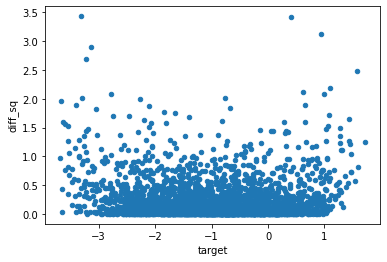

In [ ]:
train_kf_df.plot(kind='scatter', x='target', y='diff_sq')

In [ ]:
# 二乗誤差が2.0を超えるカラム
thr_ = 2.0 
train_kf_df[train_kf_df['diff_sq'] > thr_]

,id,url_legal,license,excerpt,target,standard_error,kfold,bins_tg,bins_std,bins,pred,diff_sq
59,9ea0d2788,NaN,NaN,The most important bee in the hive is naturall...,0.987862,0.594408,2,10,9,109,-0.453831,2.078479
141,bcd734621,NaN,NaN,Midas was enjoying himself in his treasure-roo...,0.943021,0.537713,0,10,5,105,-0.822759,3.117980
304,f04e03fd8,NaN,NaN,"Jupiter, two hours high, was the herald of the...",-3.229761,0.551435,1,0,6,6,-1.588812,2.692714
695,e26914a57,NaN,NaN,"Seedlings from the same fruit, and the young o...",-0.769207,0.469529,2,6,2,62,-2.189955,2.018523
741,24e00a515,https://simple.wikipedia.org/wiki/Inkpad,CC BY-SA 3.0 and GFDL,An inkpad is a small box which contains a pad ...,0.627619,0.520607,3,9,5,95,-0.825186,2.110640
990,afeb324bd,NaN,NaN,"On the morning of the 20th of March, a long se...",0.401053,0.481889,0,9,2,92,-1.448431,3.420589
1152,03b761fd9,https://simple.wikipedia.org/wiki/Larva,CC BY-SA 3.0 and GFDL,Probably the most widely accepted theory expla...,-2.778515,0.533111,2,1,5,15,-1.333335,2.088545
1412,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776,1,11,10,1110,0.006977,2.486518
1944,04ade0eb2,NaN,NaN,"While I was hailing the brig, I spied a tract ...",-3.315282,0.544735,2,0,6,6,-1.462916,3.431261
1997,bf3ea5462,https://en.wikipedia.org/wiki/Machine_learning,CC BY-SA 3.0,Machine learning is a subfield of computer sci...,-3.295576,0.614204,4,0,10,10,-1.877392,2.011246


In [ ]:
# 二乗誤差が2.0を超える文章
thr_ = 2.0 
tmp_df = train_kf_df[train_kf_df['diff_sq'] > thr_].copy()
for i in tmp_df.index:
  print(tmp_df.loc[i].target)
  #print(tmp_df.loc[i].standard_error)
  print(tmp_df.loc[i].pred)
  print(tmp_df.loc[i].excerpt)
  print('--------------------------')

0.987861812
-0.4538312554359436
The most important bee in the hive is naturally the queen. She is longer and sleeker than the others, and has a crooked sting, of which, however, she seldom makes use. Similar in form, but smaller, are the working-bees, whose sting is straight. The male bee, or drone, is thicker than the others, and stingless.
"What has the queen to do in the hive?" I asked. The old gentleman replied, "She is the mother-bee, lays all the eggs, and is so diligent that she often lays twelve hundred in a day, having a separate cell for each egg. That is her only work; for she leaves the whole care of her children to the industrious working-bees, who have various labors to perform. Some of them build cells of wax; others bring in honey on the dust of flowers, called pollen; yet others feed and take care of the young; and a small number act as body-guard to the queen."
--------------------------
0.943020903
-0.8227593302726746
Midas was enjoying himself in his treasure-room, 